In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np


import hashlib
from scipy import stats
from scipy.stats import chi2_contingency

import psycopg2 as ps 
import configparser 

import warnings
warnings.filterwarnings('ignore')

Считается, что предоставление скидок на услуги продвижения за прохождение верификации должно повысить долю верификаций. Чтобы проверить эту гипотезу, был проведён A/В тест. 

Было обнаружено следующее: 

 **1)предоставление скидок действительно помогает поднять долю верификаций**

 **2)скидки не оказывают негативного влияния на среднюю выручку за день, но ARPU в тестовой группе оказался ниже, чем в контрольной**

In [2]:
config = configparser.ConfigParser()
config.read('database_password.cfg')
DB_NAME_DEFAULT = config.get('SQL', 'DB_NAME_DEFAULT')
DB_HOST = config.get('SQL', 'DB_HOST')
DB_PORT = config.get('SQL', 'DB_PORT')
DB_DATABASE = config.get('SQL', 'DB_DATABASE')
DB_USER = config.get('SQL', 'DB_USER')
DB_PASSWORD = config.get('SQL', 'DB_PASSWORD')

In [3]:
connection = ps.connect(host = DB_HOST, port = DB_PORT, 
                        database = DB_DATABASE, user = DB_USER, 
                        password = DB_PASSWORD)

In [4]:
#датафрейм для проверки однородности выборки 
df = pd.read_sql('''SELECT experiment_group, item_region, count(distinct user_id)
                   FROM
                    (SELECT sves.user_id, sves.experiment_group, sves."UserType", uii.item_id, item_vertical,
                            item_region, uii.item_creation_time 
                    FROM services_verification_experiment_segment sves   
                    JOIN user_item_info uii on uii.user_id = sves.user_id
                    WHERE item_vertical = '1'
                    ) as a
                   GROUP BY 1,2''', connection)

In [5]:
#датафрейм для тестирования гипотезы об увеличении кол-ва верификаций 
df_verif = pd.read_sql('''SELECT 
                            sves.user_id, 
                            sves.experiment_group, 
                            CASE WHEN svd.discount_day is null 
                                THEN 0
                                ELSE 1
                            END as verification
                          FROM services_verification_experiment_segment sves 
                          LEFT JOIN services_verification_discounts svd on svd.user_id = sves.user_id 
                          ''', connection)

In [6]:
#датафрейм для тестирования гипотезы о росте выручки 
df_revenue = pd.read_sql('''SELECT 
                                sves.user_id, 
                                sves.experiment_group,
                                upi.transaction_type,
                                upi.item_id,
                                upi.event_time,
                                upi.amount_net 
                            FROM services_verification_experiment_segment sves 
                            LEFT JOIN user_payments_info upi on upi.user_id = sves.user_id
                            WHERE event_time >= '2021-09-01' or event_time is null''', connection)

В процессе совершения покупок в интернете большую роль играет доверие покупателей к продавцам: при его наличии продавцы получают больше просмотров их объявлений и, как следствие, заказов. Одним из инструментов, помогающих это доверие приобрести, является верификация - подтверждение личности владельца аккаунта. В качестве мотивации для прохождения верификации пользователям выдают галочки. Может показаться, что этого недостаточно и введение дополнительных стимулов поспособствует увеличению количества верифицированных аккаунтов. 

В связи с этим было предложено протестировать, повысится ли количество пользователей, прошедших верификацию, если за это будет предлагаться скидка на услуги продвижения. Однако важно помнить, что выдвинутая идея не должна оказывать негативный эффект на одну из ключевых метрик - выручку. 

Для проведения эксперимента была собрана выборка из активных пользователей, ещё не прошедших верификацию. Выборка была поделена на 3 группы: пользователи, которые получают галочку за верификацию(контроль), пользователи, получающие скидку 30% на услуги продвижения, и пользователи, получающие скидку 60% на услуги продвижения за прохождение верификации. 

Прежде, чем переходить к самому эксперименту, необходимо проверить сбалансированность выборки. Основным различием пользователей являются их регионы, поэтому следует выяснить, равномерно ли они представлены. Для этого данные по пользователям были сгруппированы по регионам, далее было посчитано, сколько пользователей в каждом представленном регионе оказалось в каждой группе.  

In [7]:
df.head()

,experiment_group,item_region,count
0,30_discount,1,4717
1,30_discount,10,2168
2,30_discount,11,4526
3,30_discount,12,58
4,30_discount,13,1043


Результат можно представить в виде графика:

<AxesSubplot:xlabel='item_region', ylabel='count'>

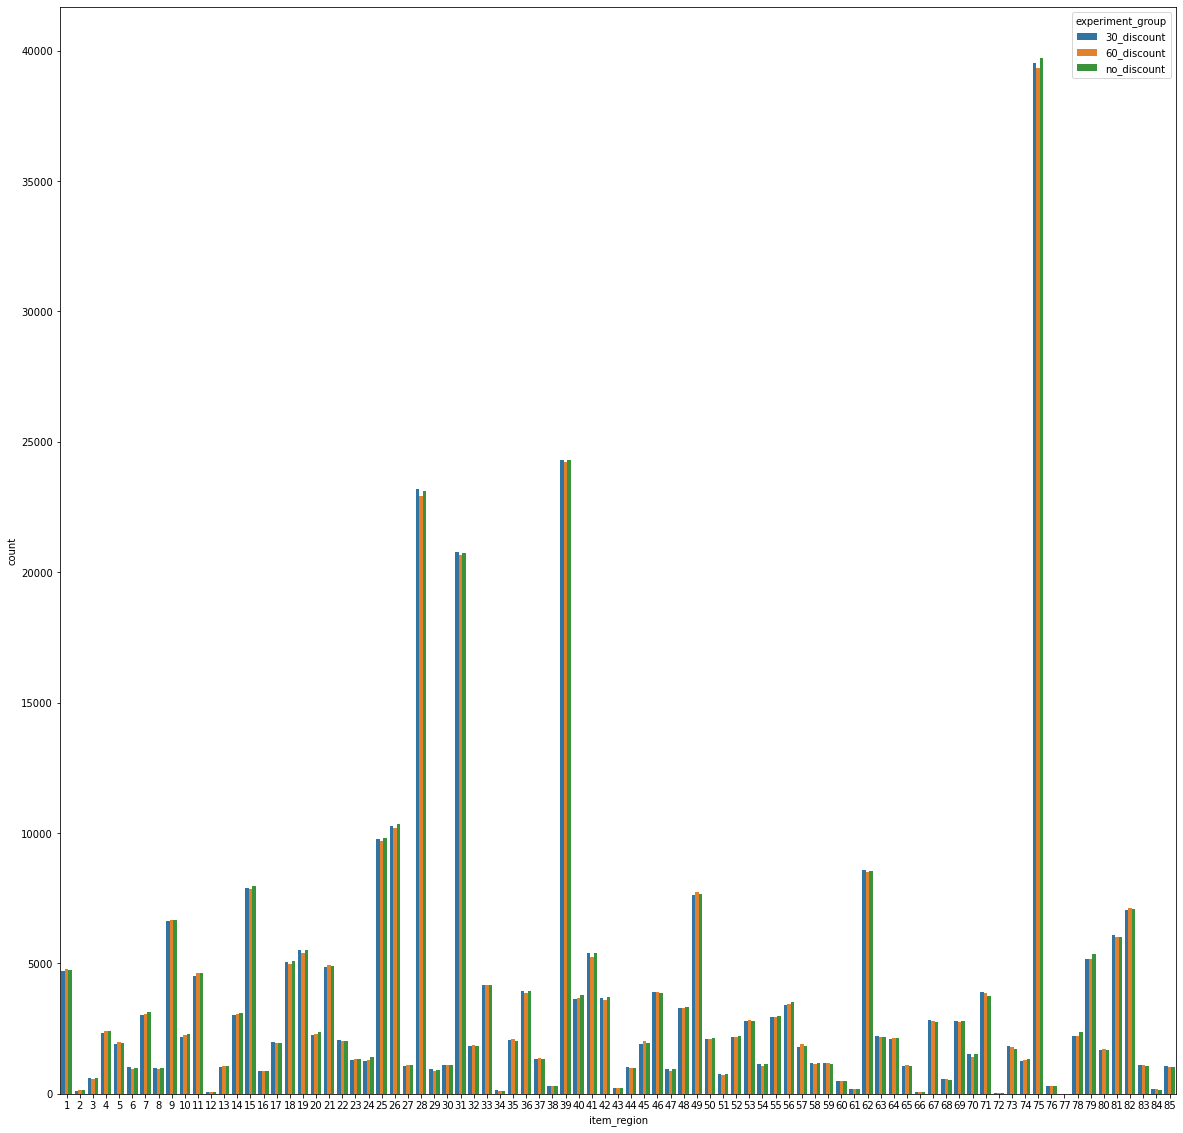

In [4]:
fig, ax = plt.subplots(figsize=(20, 20))
sns.barplot(data=df, x="item_region", y="count", hue="experiment_group" )

Визуально кажется, что внутри регионов деление на группы поделено равномерно, однако есть регионы, пользователей из которых гораздо больше, чем из других. Вероятно, это связано с тем, что какие-то регионы намного больше других, и, соответсвенно, пользователей из них также больше. Для проверки гипотезы о том, что пользователи распределены на группы независимо от региона, можно провести хи-квадрат тест: 

In [8]:
data_interim=df[['experiment_group', 'item_region']]
data_cont=pd.crosstab(df['experiment_group'], df['item_region'], df['count'], aggfunc = 'sum').fillna(0)
data_cont

item_region,1,10,11,12,13,14,15,16,17,18,...,78,79,8,80,81,82,83,84,85,9
experiment_group,,,,,,,,,,,,,,,,,,,,,
30_discount,4717.0,2168.0,4526.0,58.0,1043.0,3034.0,7891.0,866.0,2004.0,5043.0,...,2221.0,5176.0,983.0,1697.0,6093.0,7056.0,1121.0,184.0,1061.0,6610.0
60_discount,4783.0,2241.0,4652.0,74.0,1076.0,3082.0,7875.0,869.0,1966.0,4987.0,...,2216.0,5174.0,965.0,1737.0,6022.0,7133.0,1125.0,169.0,1034.0,6682.0
no_discount,4741.0,2288.0,4645.0,64.0,1075.0,3096.0,7957.0,896.0,1965.0,5110.0,...,2368.0,5348.0,980.0,1698.0,6006.0,7085.0,1058.0,155.0,1028.0,6669.0


In [9]:
stat, p, dof, expected = chi2_contingency(data_cont)
p

0.9987044868393403

Очевидно, при таком p-value нулевая гипотеза о независимости групп и регионов не может быть отвергнута. 

Как было сказано ранее, выборка собрана таким образом, что в ней представлены пользователи, не прошедшие верификацию, поэтому нет необходимости проверять одинаковы ли доли верификаций внутри теста и контроля до и после начала эксперимента. 

Проверив сбалансированность выборки, можно перейти к тестированию гипотезы об увеличении колчиества верифицированных пользователей.

In [10]:
df_verif.head()

,user_id,experiment_group,verification
0,273049750501,no_discount,1
1,5131250049,30_discount,1
2,374964778,30_discount,1
3,464891750010,30_discount,1
4,167540750020,no_discount,1


1 в столбце verification означает, что пользователь из выборки прошел верификацию за время эксперимента, 0 - не прошел.

In [17]:
number_of_users = df_verif['user_id'].count()
print(f'количество наблюдений = {number_of_users}')

количество наблюдений = 770035


В качестве самого простого инструмента для сравнения количества пройденных верификаций можно использовать bar chart:

<AxesSubplot:xlabel='experiment_group', ylabel='verification'>

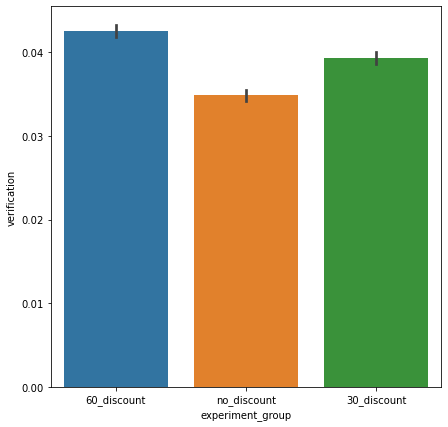

In [20]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(data=df_verif, x="experiment_group", y="verification" )

Визуально уже заметно, что количество верификаций в двух тестовых группах больше, чем в контрольной группе. 

Перейдём теперь к тестированию гипотезы об увеличении доли пользователей, прошедших верификацию. 

Важно отметить, что доля пользователей, прошедших верификацию, является ratio-метрикой, что говорит о том , что проведение простого t-теста для сравнения средних может привести к неправильным выводам, так как вероятнее всего предпосылка о нормальном распределении целевой метрики не выполняется.


Очевидно, эта предпосылка действительно нарушена:

<AxesSubplot:xlabel='verification', ylabel='Count'>

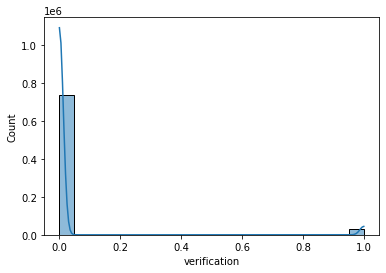

In [44]:
sns.histplot(df_verif['verification'], kde = True)

Существует множество инструменов для тестирования гипотез для ratio-метрик. Здесь предлагается воспользоваться бакетированием, которое должно помочь добиться нормального распределения целевой метрики. 

In [11]:
df_verif_1 = df_verif.reset_index()

In [15]:
options = ['60_discount', '30_discount']

In [16]:
df_verif_1["experiment_group"] = np.where(df_verif_1["experiment_group"].isin(options), 'test', 'control')

In [17]:
def get_bucket(num):
    return (int(hashlib.sha256(str(num).encode('utf-8')).hexdigest(), 16)%10**8)%200

In [18]:
df_verif_1['bucket']=df_verif_1['index'].apply(get_bucket)

In [ ]:
df_gr_verif = df_verif_1.groupby(['bucket','experiment_group']).sum()['verification'].reset_index()
control = df_gr_verif[(df_gr_verif.experiment_group=='control')]
test = df_gr_verif[(df_gr_verif.experiment_group=='test')]

<AxesSubplot:xlabel='verification', ylabel='Count'>

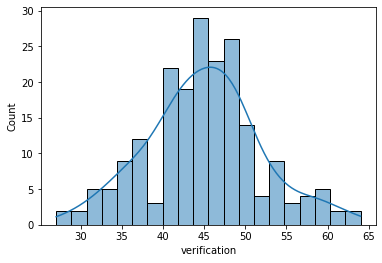

In [22]:
sns.histplot(control['verification'], bins = 20, kde = True)

<AxesSubplot:xlabel='verification', ylabel='Count'>

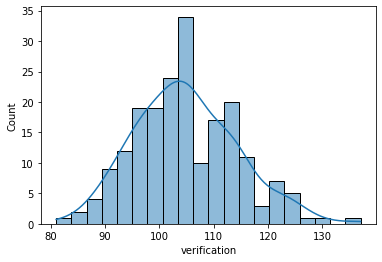

In [23]:
sns.histplot(test['verification'], bins = 20, kde = True)

Визуально распределение в контрольной группе похоже на нормальное, в то время как распределение в тестовой группе похоже на смесь двух распределений. Возможно, это связано с тем, что тестовая группа включает в себя две подгруппы - пользователи со скидкой 30% и 60%. 

In [24]:
df_gr_verif.head()

,bucket,experiment_group,verification
0,0,control,46
1,0,test,100
2,1,control,41
3,1,test,109
4,2,control,48


In [96]:
stats.ttest_ind(control.verification,test.verification, alternative = 'less') 

Ttest_indResult(statistic=-72.32051058696594, pvalue=2.3381443582850026e-231)

Как видно из p-value, нулевая гипотеза о равенстве средних отклоняется на всех приемлемых уровнях значимости в пользу альтернативной (срднее в контроле меньше, чем в тесте). Таким образом, введение скидок действительно способствует повышению доли пользователей, прошедших верификацию. 

После того, как гипотеза о повышении количества верификаций была проверена, необходимо понять, не снизило ли введение скидок на услуги продвижения выручку. Для этого были собраны данные по транзакциям пользователей с 01.09.2021 (эксперимент начался 15.09.2021)

In [25]:
df_revenue.head()

,user_id,experiment_group,transaction_type,item_id,event_time,amount_net
0,266981750030,60_discount,4,1.122839e+12,2021-09-12 19:43:13,34.307692
1,113966750040,60_discount,4,1.123247e+12,2021-09-13 12:35:45,20.384615
2,136323000055,30_discount,4,1.123250e+12,2021-09-13 12:19:12,18.538462
3,686293250066,30_discount,4,1.123294e+12,2021-09-13 14:41:20,19.692308
4,392201750266,60_discount,4,1.123295e+12,2021-09-13 14:42:32,36.615385


In [26]:
df_rev = df_revenue[['user_id','experiment_group', 'event_time', 'amount_net']]
df_rev["experiment_group"] = np.where(df_rev["experiment_group"].isin(options), 'test', 'control')

In [27]:
df_rev.head()

,user_id,experiment_group,event_time,amount_net
0,266981750030,test,2021-09-12 19:43:13,34.307692
1,113966750040,test,2021-09-13 12:35:45,20.384615
2,136323000055,test,2021-09-13 12:19:12,18.538462
3,686293250066,test,2021-09-13 14:41:20,19.692308
4,392201750266,test,2021-09-13 14:42:32,36.615385


In [28]:
df_rev_control = df_rev[df_rev['experiment_group'] == 'control']
df_rev_test = df_rev[df_rev['experiment_group'] == 'test']

Описательные статистики по выручке в контрольной группе:

In [135]:
df_rev_control['amount_net'].describe()

count    1.432113e+06
mean     2.869486e+01
std      2.180057e+01
min      1.700000e+01
25%      1.800615e+01
50%      2.047154e+01
75%      3.000000e+01
max      5.084615e+02
Name: amount_net, dtype: float64

Описательные статистики по выручке в тестовой группе:

In [136]:
df_rev_test['amount_net'].describe()

count    2.531136e+06
mean     2.988641e+01
std      2.235135e+01
min      1.700000e+01
25%      1.824308e+01
50%      2.161538e+01
75%      3.200000e+01
max      5.084615e+02
Name: amount_net, dtype: float64

Для того, чтобы сделать корректные выводы по изменению выручки, нужно также проверить, что показаетели выручки не отличаются внутри контрольной группы до и после начала эксперимента. Для этого можно провести А/А тест. Эксперимент начался 15.09.2021:

In [29]:
df_rev_test['event_time'] = pd.to_datetime(df_rev_test['event_time'])
df_rev_test['truncated'] = df_rev_test['event_time'].dt.strftime('%Y-%m-%d')

In [30]:
df_rev_control['event_time'] = pd.to_datetime(df_rev_control['event_time'])
df_rev_control['truncated'] = df_rev_control['event_time'].dt.strftime('%Y-%m-%d')

In [31]:
revenue_control_before_exp = df_rev_control[df_rev_control['event_time'] < '2021-09-15']
revenue_control_after_exp = df_rev_control[df_rev_control['event_time'] >= '2021-09-15']
revenue_test_before_exp = df_rev_test[df_rev_test['event_time'] < '2021-09-15']
revenue_test_after_exp = df_rev_test[df_rev_test['event_time'] >= '2021-09-15']

In [32]:
df_rev_control_gr3_before = revenue_control_before_exp.groupby('truncated')['amount_net'].mean()
df_rev_control_gr3_after = revenue_control_after_exp.groupby('truncated')['amount_net'].mean()
df_rev_control_gr3_before_2 = df_rev_control_gr3_before.reset_index()
df_rev_control_gr3_after_2 = df_rev_control_gr3_after.reset_index()

In [33]:
stats.ttest_ind(df_rev_control_gr3_before_2.amount_net,df_rev_control_gr3_after_2.amount_net) 

Ttest_indResult(statistic=0.9941393862356762, pvalue=0.3228203647047826)

Таким образом, нельзя отвергнуть гипотезу о равенстве средней выручки в контрольной группе до и после эксперимента.

Перейдём к выбору более подходящей метрики для оценки выручки: 

In [34]:
df_rev_test_gr = df_rev_test.groupby('truncated')['amount_net'].sum()
df_rev_control_gr = df_rev_control.groupby('truncated')['amount_net'].sum()
df_rev_test_gr2 = df_rev_test.groupby('truncated')['amount_net'].mean()
df_rev_control_gr2 = df_rev_control.groupby('truncated')['amount_net'].mean()

Для сравнения выручки в тесте и контроле выборка была сгруппирована по тестовым группам и по дням. В качестве метрик можно взять общую выручку по каждому дню эксперимента, что может быть не очень репрезентативно, так как выручка в тестовой группе изначально могла быть выше, или среднюю выручку по дням. Можно посмотреть на динамику этих метрик на графиках (пунктиром выделена дата начала эксперимента):

Средняя выручка:

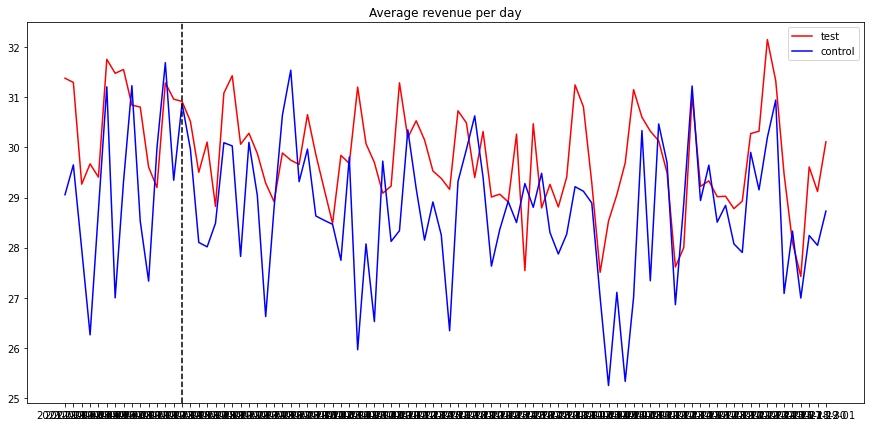

In [36]:
plt.figure(figsize = (15,7))
plt.plot(df_rev_test_gr2, label = 'test', color = 'red')
plt.plot(df_rev_control_gr2, label = 'control', color = 'blue')
plt.axvline(x='2021-09-15', color = 'black', linestyle='--')
plt.legend()
plt.title('Average revenue per day')
plt.show()

Сумма выручки за день:

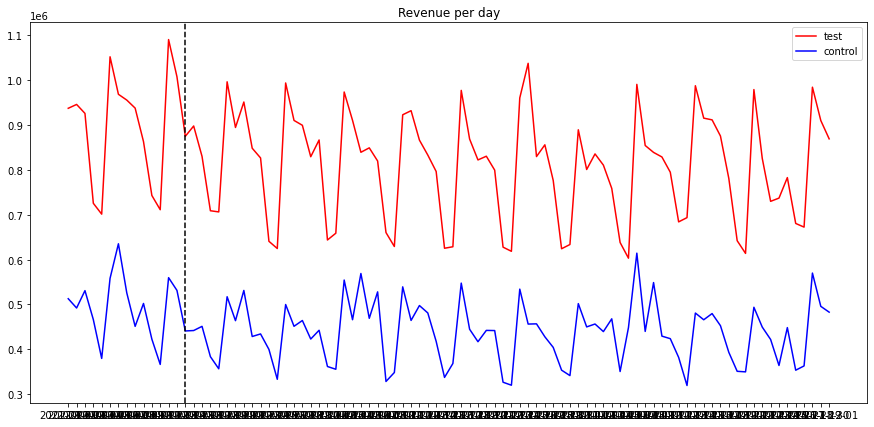

In [37]:
plt.figure(figsize = (15,7))
plt.plot(df_rev_test_gr, label = 'test', color = 'red')
plt.plot(df_rev_control_gr, label = 'control', color = 'blue')
plt.axvline(x='2021-09-15', color = 'black', linestyle='--')
plt.legend()
plt.title('Revenue per day')
plt.show()

Как и предполагалось, сумма по дням в тесте была изначально выше, чем в контрольной группе (тестовая группа больше, чем контрольная), и продолжала быть выше весь эксперимент, что говорит о том, что сравнивать тест и контроль по суммарной выручке за день не очень уместно. 

По средней выручке нельзя сделать какие-то выводы, пользуясь лишь графиком, поэтому можно провести t-test на равенство средних.



T-тест на равенство средней выручки в контроле и тесте:

In [38]:
df_rev_test_gr2_2 = revenue_test_after_exp.groupby('truncated')['amount_net'].mean().reset_index()
df_rev_control_gr2_2 = revenue_control_after_exp.groupby('truncated')['amount_net'].mean().reset_index()

In [39]:
stats.ttest_ind(df_rev_test_gr2_2.amount_net,df_rev_control_gr2_2.amount_net, alternative = 'greater') 

Ttest_indResult(statistic=5.368635131069477, pvalue=1.4343869953038743e-07)

Гипотеза о равенстве средней выручки отклоняется в пользу алтернативной, следовательно, показатель средней выручки в тестовой группе выше, чем в контроле.

Важно также посмотреть на ARPU(average revenue per user).

Проверим, что arpu не меняется после эксперимента в контрольной группе:

In [48]:
df_arpu_control = revenue_control_before_exp.groupby('truncated')
df1 = df_arpu_control['user_id'].nunique().reset_index()
df2 = df_arpu_control['amount_net'].sum().reset_index()
arpu_control_before = df1.merge(df2, on = 'truncated')
arpu_control_before['arpu'] = arpu_control_before['amount_net']/arpu_control_before['user_id']

In [49]:
stats.ttest_ind(arpu_control_before.arpu,arpu_control_after.arpu) 

Ttest_indResult(statistic=-1.1719958142958664, pvalue=0.24429187415448644)

Нельзя отвергнуть гипотезу о равенстве arpu в контрольной группе до и после эксперимента

Посмотрим на динамику ARPU на графике:

In [50]:
df_arpu_test = df_rev_test.groupby('truncated')
df8 = df_arpu_test['user_id'].nunique().reset_index()
df9 = df_arpu_test['amount_net'].sum().reset_index()
df11 = df8.merge(df9, on = 'truncated')
df11['arpu'] = df11['amount_net']/df11['user_id']

df_arpu_control = df_rev_control.groupby('truncated')
df13 = df_arpu_control['user_id'].nunique().reset_index()
df14 = df_arpu_control['amount_net'].sum().reset_index()
df12 = df13.merge(df14, on = 'truncated')
df12['arpu'] = df12['amount_net']/df12['user_id']

df_graph_test = df11[['truncated', 'arpu']]
df_graph_control = df12[['truncated', 'arpu']]

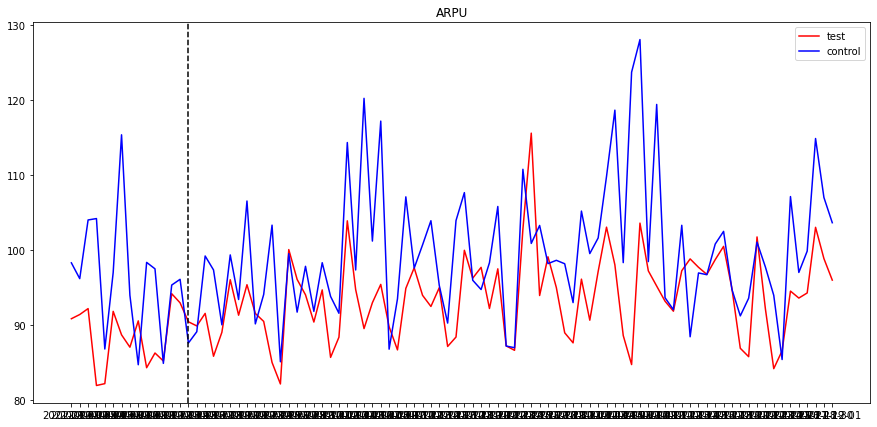

In [51]:
plt.figure(figsize = (15,7))
plt.plot(df_graph_test['truncated'],df_graph_test['arpu'], label = 'test', color = 'red')
plt.plot(df_graph_control['truncated'],df_graph_control['arpu'],label = 'control', color = 'blue')
plt.axvline(x='2021-09-15', color = 'black', linestyle='--')
plt.legend()
plt.title('ARPU')
plt.show()

In [52]:
df_arpu_test = revenue_test_after_exp.groupby('truncated')
df5 = df_arpu_test['user_id'].nunique().reset_index()
df6 = df_arpu_test['amount_net'].sum().reset_index()
arpu_test = df5.merge(df6, on = 'truncated')
arpu_test['arpu'] = arpu_test['amount_net']/arpu_test['user_id']


In [53]:
df_arpu_control = revenue_control_after_exp.groupby('truncated')
df8 = df_arpu_control['user_id'].nunique().reset_index()
df9 = df_arpu_control['amount_net'].sum().reset_index()
arpu_control_after = df8.merge(df9, on = 'truncated')
arpu_control_after['arpu'] = arpu_control_after['amount_net']/arpu_control_after['user_id']


In [47]:
stats.ttest_ind(arpu_test.arpu,arpu_control_after.arpu,alternative = 'less') 

Ttest_indResult(statistic=-4.86874581384827, pvalue=1.3792256075723144e-06)

Таким образом, гипотеза о равенстве arpu в тесте и контроле отклоняется в пользу альтернативной: arpu оказался выше в контроле, чем в тесте. 

Чтобы сделать вывод, что на это повлияло именно введение скидок, можно проверить, были ли равны arpu в тесте и контроле до эксперимента:

In [56]:
df_arpu_test = revenue_test_before_exp.groupby('truncated')
df5 = df_arpu_test['user_id'].nunique().reset_index()
df6 = df_arpu_test['amount_net'].sum().reset_index()
arpu_test = df5.merge(df6, on = 'truncated')
arpu_test['arpu'] = arpu_test['amount_net']/arpu_test['user_id']

df_arpu_control = revenue_control_before_exp.groupby('truncated')
df8 = df_arpu_control['user_id'].nunique().reset_index()
df9 = df_arpu_control['amount_net'].sum().reset_index()
arpu_control_before = df8.merge(df9, on = 'truncated')
arpu_control_before['arpu'] = arpu_control_before['amount_net']/arpu_control_before['user_id']

In [57]:
stats.ttest_ind(arpu_test.arpu,arpu_control_after.arpu,alternative = 'less') 

Ttest_indResult(statistic=-3.3337946861958163, pvalue=0.0012903154377341545)

На 0,1% уровне значимости нельзя отвергнуть гипотезу о равенстве arpu в тесте и контроле до эксперимента. То есть  некоторое влияние на снижение arpu скидки всё же оказывают 

Принимая во внимание всё вышесказанное, введение скидок действительно способствует повышению доли верицифированных пользователей. Однако, учитывая последующее за введением скидок снижение ARPU (несмотря на рост средней выручки), уместно предложить скидку 30%, а не 60%. 
